In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from glob import glob
import datetime
from RaTag.core.dataIO import load_s2area
from RaTag.scripts.run_analysis import load_config, create_run_from_config
from RaTag.workflows.run_construction import initialize_run
from RaTag.core.fitting import fit_s2_area_auto
from RaTag.plotting import plot_s2_fit_result


# Study the events in the high energy range of the S2 area histogram

In [9]:
path_config = Path(r'C:\Users\lab\Documents\Pablo\RaTag\configs\run22_analysis.yaml')
config = load_config(path_config)
run = create_run_from_config(config)
run = initialize_run(run, max_files=None)


RUN INITIALIZATION

[1/3] Gas density...
  ✓ Gas density: 4.877e+19 cm⁻³

[2/3] Populating sets...
Detected single-isotope files...
  Loaded: FieldScan_Gate0050_Anode1950 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
Detected single-isotope files...
  Loaded: FieldScan_Gate0100_Anode2000 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
Detected single-isotope files...
  Loaded: FieldScan_Gate0200_Anode2100 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
Detected single-isotope files...
  Loaded: FieldScan_Gate0300_Anode2200 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
Detected single-isotope files...
  Loaded: FieldScan_Gate0400_Anode2300 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
Detected single-isotope files...
  Loaded: FieldScan_Gate0600_Anode2500 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
Detected single-isotope files...
  Loaded: FieldScan_Gate0800_Anode2700 - 1500 files (72000 waveforms) [Fast

In [14]:
[s.source_dir.name for s in run.sets]

['FieldScan_Gate0050_Anode1950',
 'FieldScan_Gate0100_Anode2000',
 'FieldScan_Gate0200_Anode2100',
 'FieldScan_Gate0300_Anode2200',
 'FieldScan_Gate0400_Anode2300',
 'FieldScan_Gate0600_Anode2500',
 'FieldScan_Gate0800_Anode2700',
 'FieldScan_Gate1000_Anode2900',
 'FieldScan_Gate1200_Anode3100']

Text(0.5, 0.98, 'S2 areas in FieldScan_Gate0200_Anode2100')

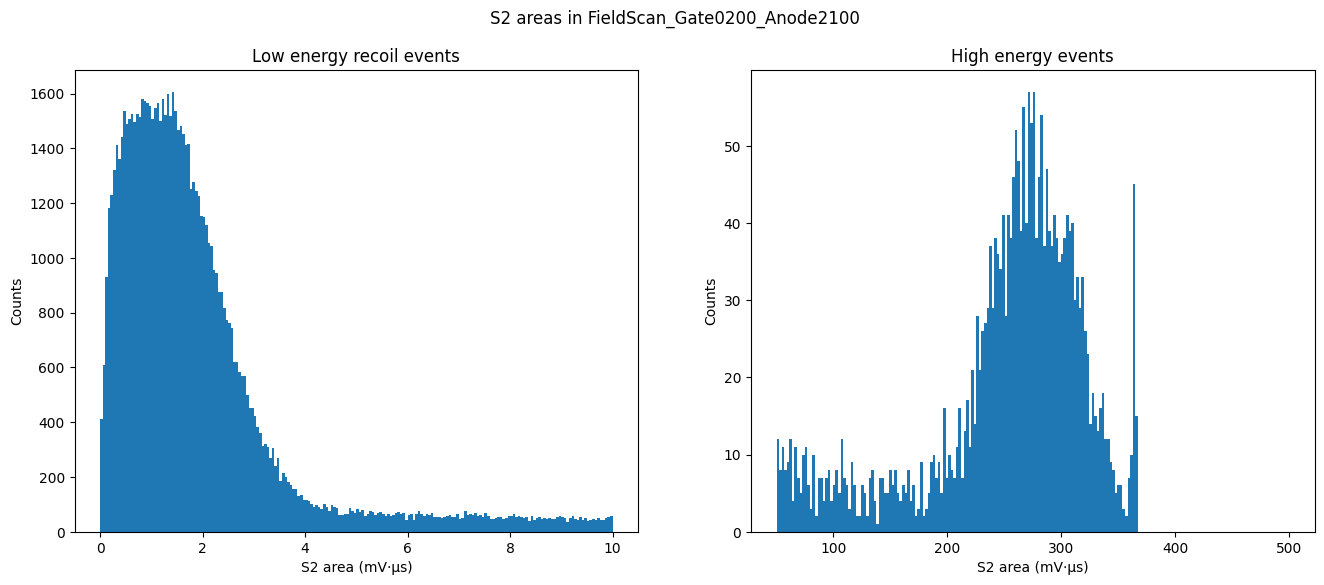

In [27]:
s2a = load_s2area(run.sets[2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.hist(s2a.areas, bins=200, range=(0, 10));
ax1.set(title=f'Low energy recoil events',
        xlabel='S2 area (mV·µs)', ylabel='Counts')
ax2.hist(s2a.areas, bins=200, range=(50, 500));
ax2.set(title=f'High energy events',
        xlabel='S2 area (mV·µs)', ylabel='Counts')
plt.suptitle(f'S2 areas in {run.sets[2].source_dir.name}')

In [67]:
from typing import Tuple, Dict, Any

from lmfit.models import GaussianModel
def _fit_background_gaussian(cbins: np.ndarray, 
                             counts: np.ndarray, 
                             bin_cuts: tuple = (0., 10)) -> Tuple[float, float, Any]:
    """    Fit Gaussian model to background region of histogram."""
    # Restrict to background region
    bg_mask = (cbins >= bin_cuts[0]) & (cbins <= bin_cuts[1])
    cbins_bg = cbins[bg_mask]
    n_bg = counts[bg_mask]
    
    # Fit Gaussian
    gauss_bg = GaussianModel(prefix='bg_')
    params_bg = gauss_bg.make_params(
        bg_amplitude=n_bg.max(),
        bg_center=cbins_bg[np.argmax(n_bg)],
        bg_sigma=20
    )
    params_bg['bg_center'].set(min=bin_cuts[0], max=bin_cuts[1])
    # params_bg['bg_sigma'].set(min=0.05, max=0.5)
    
    result_bg = gauss_bg.fit(n_bg, params=params_bg, x=cbins_bg)
    
    bg_center = result_bg.params['bg_center'].value
    bg_sigma = result_bg.params['bg_sigma'].value
    
    return bg_center, bg_sigma, result_bg




Background center: 275.35, sigma: 40.94


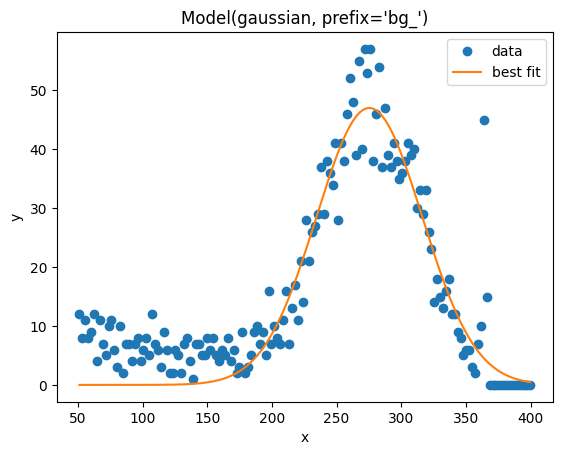

In [68]:
# s2a_fitted = fit_s2_area_auto(s2a.areas, bin_cuts=(50,400), nbins=200, bg_threshold=0.4, bg_cutoff=0.5)
# plot_s2_fit_result(s2a_fitted, s2a.areas)
counts, bins = np.histogram(s2a.areas, bins=200, range=(50, 500))
cbins = 0.5 * (bins[1:] + bins[:-1])
bg_center, bg_sigma, result_bg = _fit_background_gaussian(cbins, counts, bin_cuts=(50, 400))
result_bg.plot_fit()
print(f'Background center: {bg_center:.2f}, sigma: {bg_sigma:.2f}')

FieldScan_Gate0100_Anode2000
Background center: 264.74, sigma: 53.67
FieldScan_Gate0200_Anode2100
Background center: 275.35, sigma: 40.94
FieldScan_Gate0300_Anode2200
Background center: 239.83, sigma: 37.78
FieldScan_Gate0400_Anode2300
Background center: 222.09, sigma: 36.77
FieldScan_Gate0600_Anode2500
Background center: 230.17, sigma: 26.53
FieldScan_Gate0800_Anode2700
Background center: 220.13, sigma: 27.77
FieldScan_Gate1000_Anode2900
Background center: 234.39, sigma: 22.95
FieldScan_Gate1200_Anode3100
Background center: 230.34, sigma: 27.70


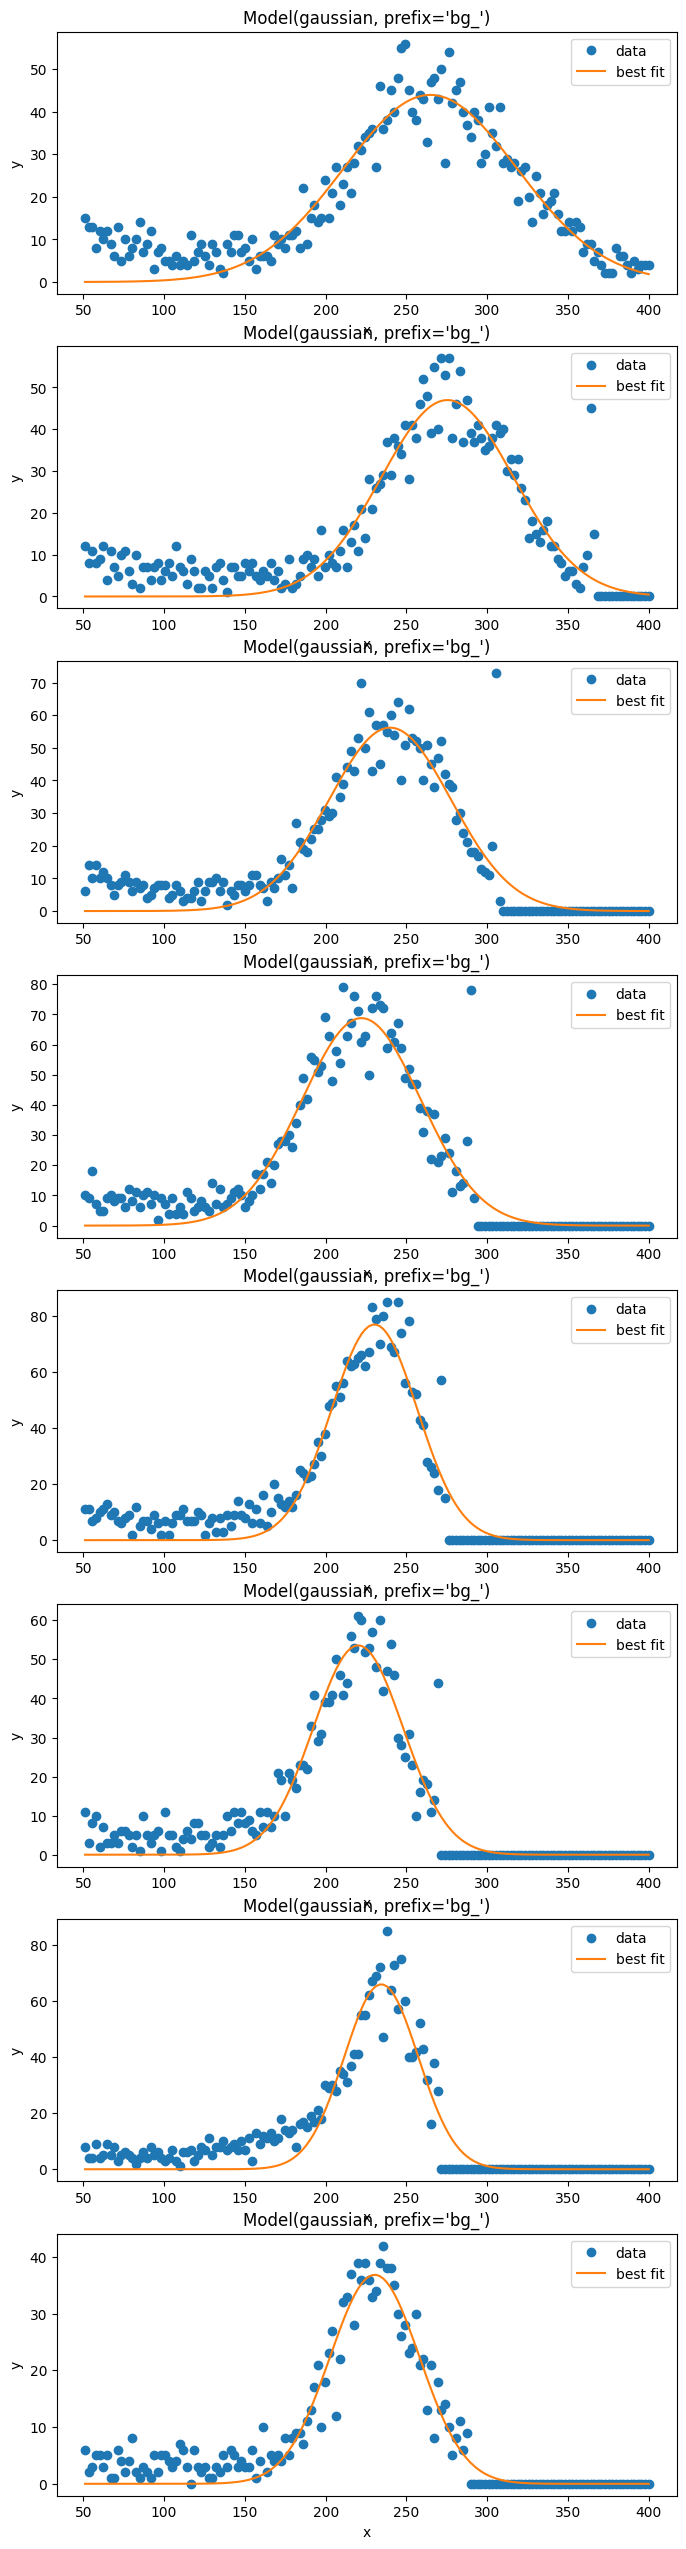

In [73]:
centers = []
sigmas = []
fig, ax = plt.subplots(len(run.sets[1:]), 1, figsize=(8, 4 * len(run.sets[1:])))
for i, s in enumerate(run.sets[1:]):
    print(s.source_dir.name)
    s2a = load_s2area(s)
    counts, bins = np.histogram(s2a.areas, bins=200, range=(50, 500))
    cbins = 0.5 * (bins[1:] + bins[:-1])
    bg_center, bg_sigma, result_bg = _fit_background_gaussian(cbins, counts, bin_cuts=(50, 400))
    result_bg.plot_fit(ax=ax[i])
    print(f'Background center: {bg_center:.2f}, sigma: {bg_sigma:.2f}')
    centers.append(bg_center)
    sigmas.append(bg_sigma)
centers = np.array(centers)
sigmas = np.array(sigmas)

In [78]:
set0 = run.sets[0]

set0.drift_field

35.714285714285715

[Text(0.5, 0, 'Drift field (V/cm)'),
 Text(0, 0.5, 'High energy S2 area center (mV·µs)'),
 Text(0.5, 1.0, 'High energy S2 area center vs Drift field')]

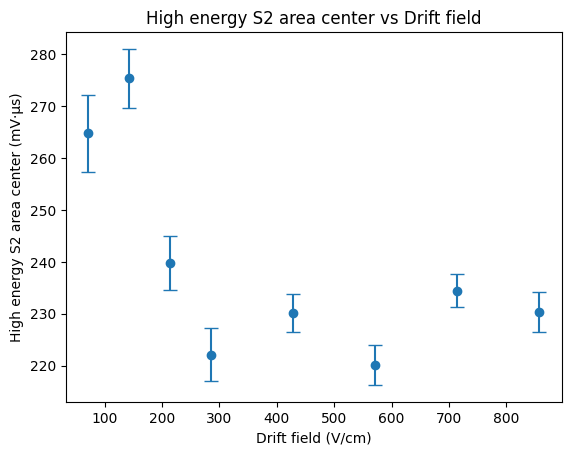

In [80]:
ci95 = 1.96 * sigmas / np.sqrt(len(bins))
drift_fields = [s.drift_field for s in run.sets[1:]]
plt.errorbar(drift_fields, centers, yerr=ci95, fmt='o', capsize=5)
plt.gca().set(xlabel='Drift field (V/cm)', ylabel='High energy S2 area center (mV·µs)', title='High energy S2 area center vs Drift field')

In [83]:
A_alphas = np.mean(centers)
A_alphas_err = np.std(centers) / np.sqrt(len(centers))
print(f'Average high energy S2 area center: {A_alphas:.2f} ± {A_alphas_err:.2f} mV·µs')

Average high energy S2 area center: 239.63 ± 6.61 mV·µs


GS2 factor: 0.00359 ± 0.00014 mV·µs / e-

In [82]:
gs2 = 0.00359  # mV·µs / e-
gs2_err = 0.00014  # mV·µs / e-

In [84]:
N_alphas = A_alphas / gs2
N_alphas_err = N_alphas * np.sqrt( (A_alphas_err / A_alphas)**2 + (gs2_err / gs2)**2 )
print(f'Number of electrons for high energy S2 events: {N_alphas:.0f} ± {N_alphas_err:.0f} e-')

Number of electrons for high energy S2 events: 66749 ± 3189 e-


In [90]:
E_alpha = 5423.15 # keV
W_value = 22.0 # e- / eV
N_expect_alphas = E_alpha * 1000 / W_value # e-
print(f'Expected number of electrons for alphas: {N_expect_alphas:.0f} e-')

Expected number of electrons for alphas: 246507 e-


In [91]:
recomb_factor = 1 - (N_alphas / N_expect_alphas)
recomb_factor_err = (N_alphas_err / N_expect_alphas)
print(f'Recombination factor for alpha events: {recomb_factor:.4f} ± {recomb_factor_err:.4f}')

Recombination factor for alpha events: 0.7292 ± 0.0129
